In [1]:
import pandas as pd
import os

In [2]:
topic = 'atheism'
scheme = 'EII'

path = os.getcwd()
clean_path = f'{path}/clean'
NN_path = f'{path}/NN/{topic}/{scheme}'

train_file = f'{path}/train/labeled_{topic}_train.csv'
test_file = f'{path}/test/labeled_{topic}_test.csv'

os.makedirs(NN_path, exist_ok=True)
os.makedirs(f'{clean_path}/train', exist_ok=True)
os.makedirs(f'{clean_path}/test', exist_ok=True)

NN_path

'/media/rinnely/Archer/ENES/Stance/Clasificador/NN/atheism/EII'

In [ ]:
train = pd.read_csv(train_file)

In [ ]:
train.head()

In [ ]:
train = train[[f'Label_{scheme}', 'Tweet']]
train.columns = ['Label', 'Tweet']

In [ ]:
train.head()

In [ ]:
train.Label.unique()

In [ ]:
train = train.query('Label != 0')
train.Label.unique()

In [ ]:
train.groupby('Label').count()

In [ ]:
test = pd.read_csv(test_file)
test.head()

In [ ]:
test = test[['Stance', 'Tweet']]
test.Stance.unique()

In [ ]:
test['Stance']= test.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'C':0})
test = test.query('Stance != 0')
test.Stance.unique()

In [ ]:
test.columns = ['Label', 'Tweet']
test.groupby('Label').count()

In [ ]:
train.shape, test.shape

# clean data

In [3]:
import sys
sys.path.insert(0, '/media/rinnely/Archer/ENES/Stance')
import cleandata as cd

In [ ]:
train = cd.cleanData(train.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
test = cd.cleanData(test.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')

In [ ]:
train = train.dropna(axis=0)

# save data

In [ ]:
train.to_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv', index=False)
test.to_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv', index=False)

# read data

In [4]:
train = pd.read_csv(f'{clean_path}/train/clean_{topic}_{scheme}_train.csv')
test = pd.read_csv(f'{clean_path}/test/clean_{topic}_{scheme}_test.csv')

In [ ]:
train['Label'].value_counts().plot.pie(legend=True)

In [ ]:
test['Label'].value_counts().plot.pie(legend=True)

In [ ]:
train['Label'].value_counts().plot.bar(legend=True)

In [ ]:
test['Label'].value_counts().plot.bar(legend=True)

In [ ]:
train

In [ ]:
train.info()

In [ ]:
test.info()

In [ ]:
train = train.dropna(axis=0)

In [ ]:
train.info()

# Training

In [5]:
from fastai.text import *

In [6]:
data_lm = (TextList.from_df(train, NN_path, cols='Tweet')
          .split_by_rand_pct(0.2)
          .label_for_lm() # this does the tokenization and numericalization
          .databunch())

/home/rinnely/anaconda3/lib/python3.8/site-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


In [ ]:
data_lm.show_batch()

In [7]:
data_clas = TextClasDataBunch.from_df(NN_path, train_df=train, 
                                      valid_df=test, 
                                      vocab=data_lm.vocab, 
                                      text_cols = 'Tweet', 
                                      label_cols = 'Label',
                                      bs=32)

/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
data_clas.show_batch()

In [ ]:
f'data_clas_{topic}_{scheme}'

In [ ]:
data_lm.save(f'data_lm_{topic}_{scheme}')
data_clas.save(f'data_clas_{topic}_{scheme}')

In [ ]:
data_lm.train_ds.vocab.itos[:10], len(data_lm.train_ds.vocab.itos)

In [8]:
#learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.2)
learn_lm = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=.5)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-02
Min loss divided by 10: 5.25E-02


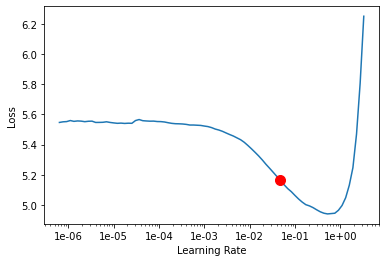

In [9]:
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [10]:
learn_lm.fit_one_cycle(5,4e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.044489,3.414742,0.362656,00:26
1,3.573950,3.317147,0.385681,00:26
2,3.259924,3.258849,0.395458,00:26
3,2.957335,3.197731,0.405145,00:27
4,2.720514,3.186192,0.408237,00:27


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 9.12E-07
Min loss divided by 10: 2.29E-07


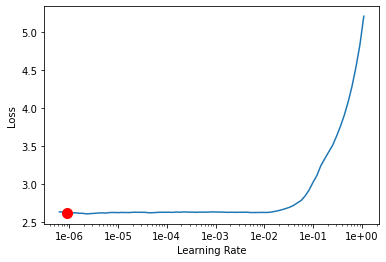

In [11]:
learn_lm.unfreeze()
learn_lm.lr_find(); learn_lm.recorder.plot(suggestion=True)

In [12]:
learn_lm.fit_one_cycle(3)

epoch,train_loss,valid_loss,accuracy,time
0,2.616191,3.152083,0.415246,00:37
1,2.519365,3.124167,0.420815,00:37
2,2.405566,3.133482,0.421507,00:37


In [13]:
learn_lm.save_encoder(f'{topic}_ml_encoder_v1')

In [14]:
learn_lm.load_encoder(f'{topic}_ml_encoder_v1');

In [15]:
learn_lm.save(f'{topic}_model_v1')

In [16]:
learn_lm.load(f'{topic}_model_v1');

In [17]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)

In [18]:
from sklearn.metrics import f1_score

@np_func #converts torch tesnsor as numpy array
def f1_macro(inp, targ): return f1_score(targ, np.argmax(inp, axis=1), average='macro')

In [19]:
learn.load_encoder(f'{topic}_ml_encoder_v1')
learn.metrics=[f1_macro]
learn.freeze()

In [20]:
learn.save('learner-1stage')

In [21]:
learn.load('learner-1stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.74E-02


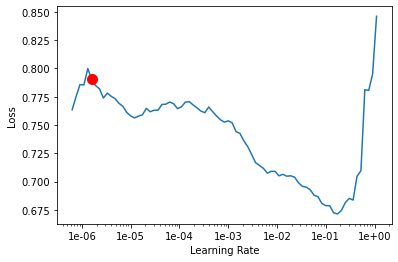

In [22]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [23]:
learn.fit_one_cycle(5,1e-6,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.772768,0.761922,0.444988,00:22
1,0.737587,0.743875,0.449227,00:20
2,0.730887,0.670474,0.508487,00:21
3,0.733978,0.681059,0.508648,00:21
4,0.723615,0.668484,0.512413,00:21


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [24]:
learn.save('learner-2stage')

In [25]:
learn.load('learner-2stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 6.92E-03


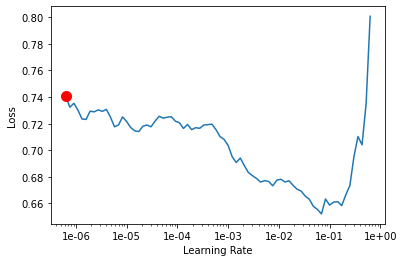

In [26]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [27]:
learn.fit_one_cycle(3, 6e-7,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.715766,0.654741,0.523903,00:22
1,0.711669,0.659989,0.531040,00:22
2,0.704316,0.638442,0.534150,00:22


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [28]:
learn.save('learner-3stage')

In [29]:
learn.load('learner-3stage');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-04
Min loss divided by 10: 8.32E-03


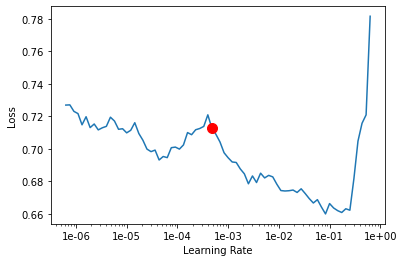

In [30]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 4.37E-04


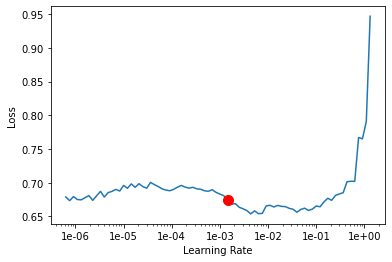

In [31]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(5,5e-5,moms=(0.8, 0.7));

In [ ]:
learn.save('learner-stage-freeze-2')

In [ ]:
learn.save('learner-stage-freeze-2')

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.63E-04


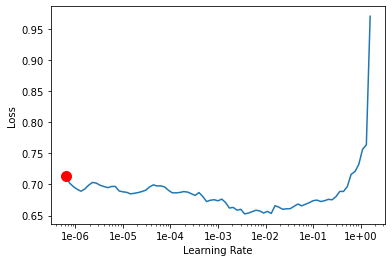

In [32]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [33]:
learn.fit_one_cycle(3, 6e-7, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.712891,0.685250,0.509021,00:49
1,0.686655,0.637280,0.533292,00:45
2,0.691042,0.613993,0.560291,00:50


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [34]:
learn.save('learner-stage-freeze-3')

In [35]:
learn.load('learner-stage-freeze-3');

epoch,train_loss,valid_loss,f1_macro,time


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


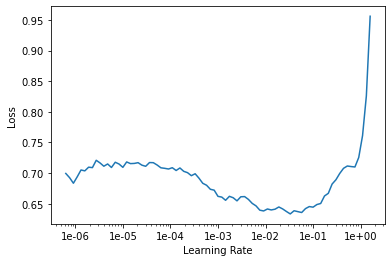

In [36]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot()

In [37]:
learn.fit_one_cycle(3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,f1_macro,time
0,0.483609,0.485941,0.595836,00:57
1,0.370101,0.527024,0.602034,01:01
2,0.311329,0.572778,0.594157,00:58


/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/home/rinnely/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [38]:
data = pd.read_csv(train_file)
data.head()
data['NNAgainst'] = ''
data['NNFavor'] = ''
data.head()
data = cd.cleanData(data.copy(), label='Tweet', hashtags=True, urls='URL', emojis=True, users='USER')
data.head()

,id,Tweet,Label_EI,Stance_EI,Label_EII,Stance_EII,NNAgainst,NNFavor
0,1.344430e+18,Is Belief in God a Delusion? - Neuroscience Ne...,-1,Against,1,Favor,,
1,1.344427e+18,"I haven’t even been on twitter for a week, I h...",0,Uknown,1,Favor,,
2,1.344426e+18,The Crabs are LIVE RIGHT NOW--&gt; URL,0,Uknown,0,Uknown,,
3,1.344422e+18,Watching people feel devotional by bathing the...,-1,Against,0,Uknown,,
4,1.344420e+18,Some of the benefits of Christianity cited by ...,0,Uknown,0,Uknown,,


In [39]:
from tqdm.notebook import tqdm, trange
import time 
for i in trange(data.shape[0]):
    #time.sleep(0.01)
    data.loc[i,'Tweet']
    result = learn.predict(data.loc[i,'Tweet'])
    r = result[2].numpy()
    data.loc[i,'NNAgainst'] = r[0]
    data.loc[i,'NNFavor'] = r[1]

  0%|          | 0/17692 [00:00<?, ?it/s]

In [45]:
data['NNPred'] = data[['NNFavor','NNAgainst']].apply(lambda x : 1 if x[0] >= 0.70 else( -1 if x[1] >= 0.70 else 0 ),axis=1)

In [46]:
data

,id,Tweet,Label_EI,Stance_EI,Label_EII,Stance_EII,NNAgainst,NNFavor,NNPred
0,1.344430e+18,Is Belief in God a Delusion? - Neuroscience Ne...,-1,Against,1,Favor,0.943809,0.056191,-1
1,1.344427e+18,"I haven’t even been on twitter for a week, I h...",0,Uknown,1,Favor,0.805741,0.194259,-1
2,1.344426e+18,The Crabs are LIVE RIGHT NOW--&gt; URL,0,Uknown,0,Uknown,0.820663,0.179337,-1
3,1.344422e+18,Watching people feel devotional by bathing the...,-1,Against,0,Uknown,0.91898,0.08102,-1
4,1.344420e+18,Some of the benefits of Christianity cited by ...,0,Uknown,0,Uknown,0.876998,0.123002,-1
...,...,...,...,...,...,...,...,...,...
17687,1.218972e+18,"Sam Harris Net Worth – $2,500,000 URL URL",0,Uknown,0,Uknown,0.763992,0.236008,-1
17688,1.218934e+18,"Yay!!!!! Jack Van Impe, an Apocalyptic Televan...",0,Uknown,0,Uknown,0.508123,0.491877,0
17689,1.218928e+18,The New York Public Library Has Calculated Its...,0,Uknown,0,Uknown,0.267955,0.732045,1
17690,1.218926e+18,Being a Humanist means trying to behave decent...,1,Favor,1,Favor,0.093845,0.906155,1


In [47]:
data.to_csv('/media/rinnely/Archer/ENES/Stance/Clasificador/train/labeled_atheism_NNtrain.csv', index=False)

In [41]:
learn.save('learner-stage-unfreeze-62')

In [42]:
learn.load('learner-stage-unfreeze-62');

In [43]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = TextClassificationInterpretation(learn, preds, y, losses)

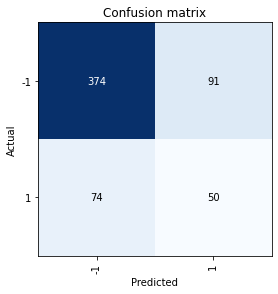

In [44]:
interp.plot_confusion_matrix()

In [ ]:
preds

In [ ]:
learn.save('learner-final')